In [2]:
import yfinance as yf
import matplotlib.pyplot as plt

[*********************100%%**********************]  1 of 1 completed

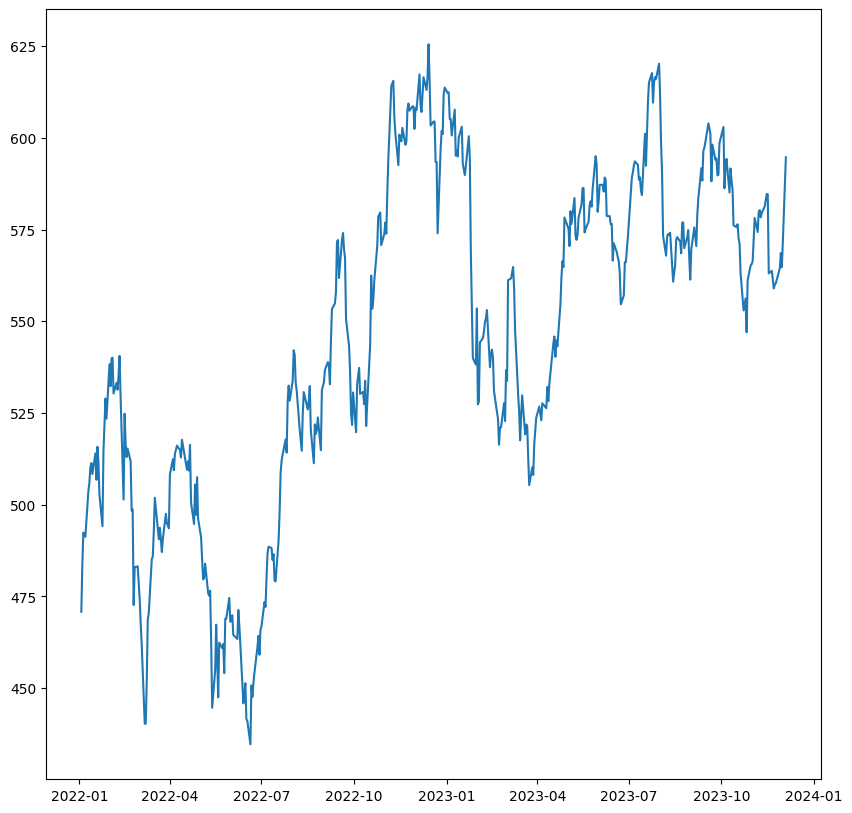

<Figure size 640x480 with 0 Axes>

In [9]:
data = yf.download("SBIN.NS", start="2022-01-01", end="2023-12-05")

# Plot the closing price
plt.figure(figsize=(10, 10))
plt.plot(data["Close"])
# plt.title('SBI.NS Closing Price')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
plt.grid(False)
plt.show()
plt.savefig(
    fname="sbin.png",
    transparent=True,
    dpi=1200,
    format="png",
    bbox_inches="tight",
    pad_inches=0,
)

In [20]:
import polars as pl
import pandas as pd


file_path = "../datasets/LabelTradeSBI.NS.xlsx"
sbi_data = pd.read_excel(file_path)

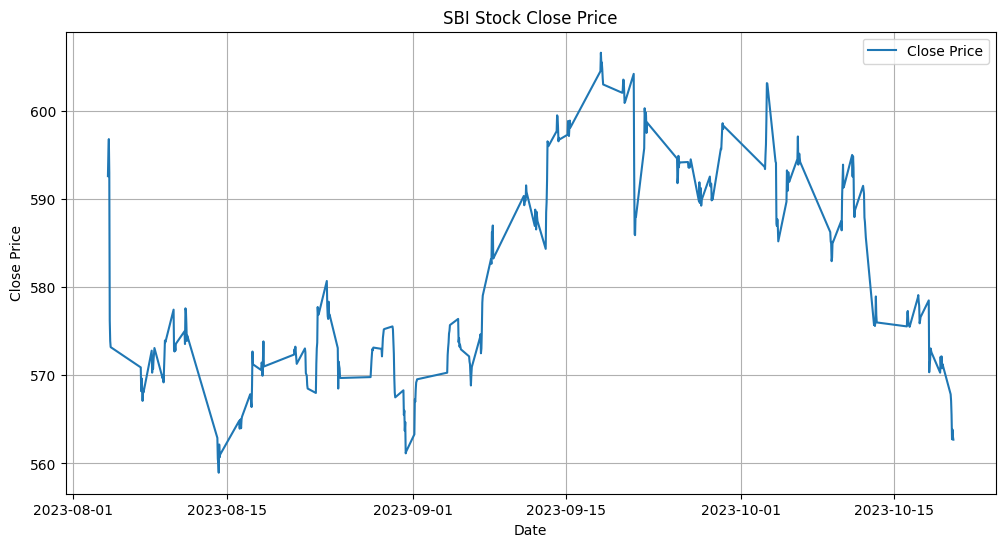

In [24]:
import matplotlib.pyplot as plt

# Plotting the Close price
plt.figure(figsize=(12, 6))
plt.plot(sbi_data["Datetime"], sbi_data["Close"], label="Close Price")
plt.title("SBI Stock Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

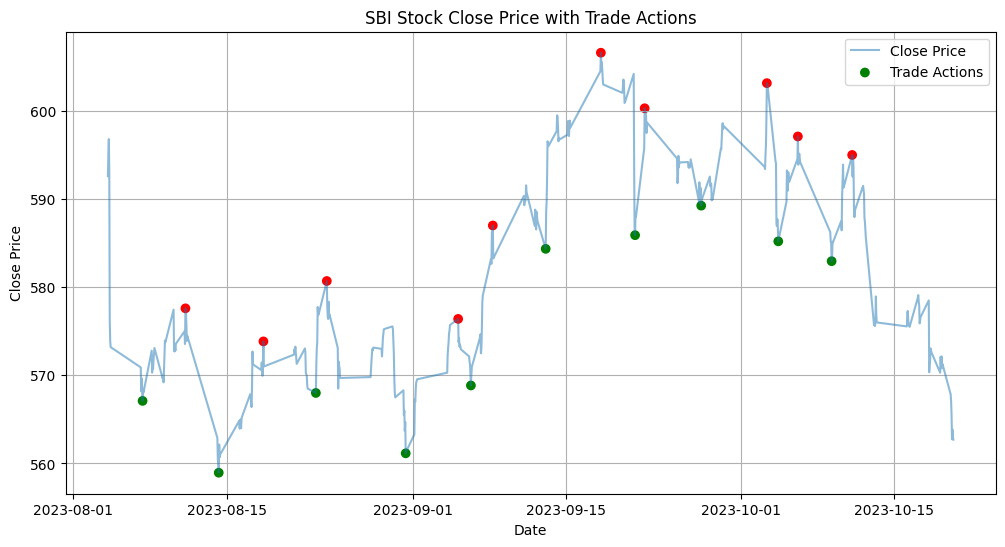

In [25]:
# Filtering rows with action labels other than 'HOLD'
trade_data = sbi_data[sbi_data["Actions"] != "HOLD"]

# Plotting the Close price with trade actions
plt.figure(figsize=(12, 6))
plt.plot(sbi_data["Datetime"], sbi_data["Close"], label="Close Price", alpha=0.5)
plt.scatter(
    trade_data["Datetime"],
    trade_data["Close"],
    c=trade_data["Actions"].map({"BUY": "green", "SELL": "red"}),
    label="Trade Actions",
)
plt.title("SBI Stock Close Price with Trade Actions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
def backtest_strategy(data, initial_capital=10000):
    capital = initial_capital
    shares_held = 0
    transaction_log = []

    for index, row in data.iterrows():
        if row["Actions"] == "BUY" and capital >= row["Close"]:
            shares_bought = capital // row["Close"]
            capital -= shares_bought * row["Close"]
            shares_held += shares_bought
            transaction_log.append(
                (row["Datetime"], "BUY", shares_bought, row["Close"], capital)
            )

        elif row["Actions"] == "SELL" and shares_held > 0:
            capital += shares_held * row["Close"]
            transaction_log.append(
                (row["Datetime"], "SELL", shares_held, row["Close"], capital)
            )
            shares_held = 0

    # Calculate the final value (capital + value of held shares)
    final_value = capital + (shares_held * data.iloc[-1]["Close"])

    return final_value, transaction_log


# Performing the backtest on the strategy
final_value, transactions = backtest_strategy(trade_data)
final_value

12801.598754882834

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Preprocessing
# Selecting relevant features and the target variable
features = sbi_data[
    [
        "RSI",
        "EMA9",
        "EMA21",
        "MACD",
        "MACD_SIGNAL",
        "BBANDS_UPPER",
        "BBANDS_MIDDLE",
        "BBANDS_LOWER",
        "ADX",
        "STOCH_K",
        "STOCH_D",
        "ATR",
        "CCI",
        "MOM",
        "ROC",
        "WILLR",
        "PPO",
    ]
]
target = sbi_data["Actions"]

# Encoding the target variable (BUY: 1, SELL: -1, HOLD: 0)
target_encoded = target.map({"BUY": 1, "SELL": -1, "HOLD": 0})

# Normalizing the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_normalized, target_encoded, test_size=0.2, random_state=42
)

# Model Selection and Training
# Using Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.96

In [30]:
# Making predictions on the entire dataset
all_predictions = rf_model.predict(features_normalized)

# Adding predictions to the dataframe
sbi_data["ML_Actions"] = all_predictions
sbi_data["ML_Actions"] = sbi_data["ML_Actions"].map({1: "BUY", -1: "SELL", 0: "HOLD"})

# Filter out rows where ML prediction is not 'HOLD'
ml_trade_data = sbi_data[sbi_data["ML_Actions"] != "HOLD"]

# Performing the backtest on the ML strategy
ml_final_value, ml_transactions = backtest_strategy(ml_trade_data)
ml_final_value, ml_transactions[
    :5
]  # Displaying the final value and first few transactions

(12059.849243164059,
 [(Timestamp('2023-08-07 07:45:00'),
   'BUY',
   17.0,
   567.099975585938,
   359.3004150390552),
  (Timestamp('2023-08-11 05:45:00'), 'SELL', 17.0, 577.599975585938, 10178.5),
  (Timestamp('2023-08-23 03:45:00'), 'BUY', 17.0, 568.0, 522.5),
  (Timestamp('2023-08-24 03:45:00'),
   'SELL',
   17.0,
   580.700012207031,
   10394.400207519528),
  (Timestamp('2023-08-31 08:45:00'),
   'BUY',
   18.0,
   561.150024414063,
   293.69976806639534)])

In [33]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,462.000000,472.000000,460.100006,470.799988,454.729004,13124509
2022-01-04,472.500000,484.700012,471.049988,483.500000,466.995483,23296671
2022-01-05,481.899994,495.000000,479.149994,492.399994,475.591675,24694169
2022-01-06,487.700012,494.399994,485.399994,491.700012,474.915588,18190843
2022-01-07,493.450012,501.950012,489.450012,491.250000,474.480927,22746330
...,...,...,...,...,...,...
2023-11-28,563.599976,565.200012,561.099976,564.450012,564.450012,8153314
2023-11-29,568.000000,569.000000,565.099976,568.599976,568.599976,10299034
2023-11-30,569.750000,570.200012,563.650024,564.750000,564.750000,19758998


In [29]:
from datetime import timedelta
import polars as pl

df = pl.read_parquet("../datasets/SBIN.NS")
array = (
    df.with_columns(index=pl.int_range(0, df.shape[0], eager=True))
    .sort("index")
    .set_sorted("index")
    .group_by_dynamic(
        "index", every="1i", period="40i", include_boundaries=True, closed="right"
    )
    .agg(pl.col("Close"))
    .with_columns(pl.col("Close").list.len().alias("Count"))
    .filter(pl.col("Count") == 40)["Close"]
    .to_numpy()
)
array

array([array([462.45001221, 463.79998779, 461.5       , 459.54998779,
              457.95001221, 462.8500061 , 462.70001221, 465.1499939 ,
              466.8999939 , 467.1000061 , 468.        , 462.        ,
              445.3500061 , 440.54998779, 454.1000061 , 458.3999939 ,
              454.6000061 , 454.8500061 , 457.95001221, 454.04998779,
              455.95001221, 458.1000061 , 458.1499939 , 461.75      ,
              462.70001221, 466.        , 467.04998779, 467.45001221,
              465.25      , 463.54998779, 464.        , 461.3999939 ,
              460.6000061 , 457.6499939 , 458.        , 448.95001221,
              447.3999939 , 446.8999939 , 447.3999939 , 447.20001221]),
       array([463.79998779, 461.5       , 459.54998779, 457.95001221,
              462.8500061 , 462.70001221, 465.1499939 , 466.8999939 ,
              467.1000061 , 468.        , 462.        , 445.3500061 ,
              440.54998779, 454.1000061 , 458.3999939 , 454.6000061 ,
              454.

In [45]:
import numpy as np

np.concatenate((array[0], (10, 10, 10)))

array([462.45001221, 463.79998779, 461.5       , 459.54998779,
       457.95001221, 462.8500061 , 462.70001221, 465.1499939 ,
       466.8999939 , 467.1000061 , 468.        , 462.        ,
       445.3500061 , 440.54998779, 454.1000061 , 458.3999939 ,
       454.6000061 , 454.8500061 , 457.95001221, 454.04998779,
       455.95001221, 458.1000061 , 458.1499939 , 461.75      ,
       462.70001221, 466.        , 467.04998779, 467.45001221,
       465.25      , 463.54998779, 464.        , 461.3999939 ,
       460.6000061 , 457.6499939 , 458.        , 448.95001221,
       447.3999939 , 446.8999939 , 447.3999939 , 447.20001221,
        10.        ,  10.        ,  10.        ])